训练集大小: 5000
测试集大小: 1000
使用设备: cuda
Epoch [1/10], Loss: 0.0318
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Accuracy of the model on the test images: 100.00%


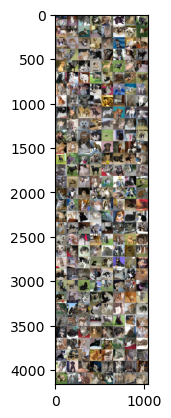

预测结果： both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_cats_and_dogs both_c

In [1]:
# 处理冲突
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 导入模块
import torchvision as tv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from PIL import Image

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 定义简单的卷积神经网络
class mycnn(nn.Module):
    def __init__(self):
        super(mycnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if __name__ == '__main__':
    # 加载数据集和测试集
    full_train_dataset = datasets.ImageFolder(root='../data/train', transform=transform)
    full_test_dataset = datasets.ImageFolder(root='../data/test', transform=transform)


    # 正确的数据集切片方式
    train_dataset = Subset(full_train_dataset, range(min(5000, len(full_train_dataset))))
    test_dataset = Subset(full_test_dataset, range(min(1000, len(full_test_dataset))))

    print(f"训练集大小: {len(train_dataset)}")
    print(f"测试集大小: {len(test_dataset)}")

    # 创建数据加载器
    train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

    # 初始化模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    model = mycnn().to(device)

    # 开始训练模型
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 开始循环
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        runnning_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            runnning_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {runnning_loss / len(train_loader):.4f}")

    # 测试模型的性能
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 输出模型的准确率
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # 随机显示一些测试图像以及预测结果
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # 显示图像和预测结果
    imshow(tv.utils.make_grid(images.cpu()))
    print("预测结果：", ' '.join(f'{full_test_dataset.classes[predicted[j]]}' for j in range(len(predicted))))
    print("实际标签：", ' '.join(f'{full_test_dataset.classes[labels[j]]}' for j in range(len(labels))))

    # 保存模型
    torch.save(model.state_dict(), 'mycnn_model.pth')


为了生成文档，我将为 `train.ipynb` 文件中的代码撰写详细的说明文档。该代码实现了一个简单的卷积神经网络（CNN），用于图像分类任务，包括数据预处理、模型定义、训练、测试和结果可视化。

以下是完整的文档内容：

---

# 图像分类模型训练文档

## 1. 环境配置
- **操作系统**: Windows 24H2
- **IDE**: PyCharm 2025.1.1.1
- **Python 版本**: Python 3.x
- **依赖库**:
  - `torch`
  - `torchvision`
  - `numpy`
  - `matplotlib`
  - `pandas`
  - `PIL`

---

## 2. 数据集结构

```
E:\Cat_or_Dog
└── data
    ├── train
    │   ├── cat
    │   └── dog
    └── test
        ├── cat
        └── dog
```


- **训练集路径**: `../data/train`
- **测试集路径**: `../data/test`

---

## 3. 代码功能概述

### 3.1 数据预处理
使用 `transforms.Compose` 对图像进行标准化处理：
- 调整大小至 `(128, 128)`
- 转换为张量
- 归一化：均值 `[0.5, 0.5, 0.5]`，标准差 `[0.5, 0.5, 0.5]`

```python
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
```


### 3.2 模型定义
定义了一个简单的 CNN 模型 `mycnn`，包含两个卷积层和两个全连接层：

```python
class mycnn(nn.Module):
    def __init__(self):
        super(mycnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
```


### 3.3 数据加载
使用 `ImageFolder` 加载数据集，并通过 `Subset` 控制训练集和测试集的大小：

```python
full_train_dataset = datasets.ImageFolder(root='../data/train', transform=transform)
full_test_dataset = datasets.ImageFolder(root='../data/test', transform=transform)

train_dataset = Subset(full_train_dataset, range(min(5000, len(full_train_dataset))))
test_dataset = Subset(full_test_dataset, range(min(1000, len(full_test_dataset))))

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
```


### 3.4 模型训练
- 使用 `CrossEntropyLoss` 作为损失函数
- 使用 `Adam` 优化器
- 训练轮次：10 次

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = mycnn().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
```


### 3.5 模型评估
计算模型在测试集上的准确率并显示预测结果：

```python
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
```


### 3.6 可视化
使用 `imshow` 函数显示测试集中的部分图像及其预测结果：

```python
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

imshow(tv.utils.make_grid(images.cpu()))
print("预测结果：", ' '.join(f'{full_test_dataset.classes[predicted[j]]}' for j in range(len(predicted))))
print("实际标签：", ' '.join(f'{full_test_dataset.classes[labels[j]]}' for j in range(len(labels))))
```


### 3.7 模型保存
训练完成后，模型参数将被保存到 `mycnn_model.pth` 文件中：

```python
torch.save(model.state_dict(), 'mycnn_model.pth')
```


---

## 4. 运行流程总结

1. **环境准备**
   - 安装所需库 (`torch`, `torchvision`, `numpy`, `matplotlib`)
   - 确保 GPU 可用（推荐）

2. **数据准备**
   - 构建符合要求的数据目录结构
   - 将训练集和测试集分别放在 `data/train` 和 `data/test` 目录下

3. **模型训练**
   - 执行训练代码
   - 观察每轮训练的损失变化

4. **模型评估**
   - 查看测试集上的准确率
   - 显示部分测试图像及预测结果

5. **模型保存**
   - 模型参数保存为 `mycnn_model.pth`

---

## 5. 注意事项

- **GPU 支持**: 如果有 CUDA 兼容的 GPU，建议启用以加速训练。
- **数据增强**: 可以添加更多的数据增强操作来提高泛化能力。
- **超参数调整**: 可以尝试不同的学习率、批大小等以获得更好的性能。
- **模型复杂度**: 当前模型较为简单，可根据需求增加层数或通道数以提升性能。

---

以上是 `train.ipynb` 的完整文档说明。如需进一步扩展，请根据具体需求修改模型结构或训练策略。